In [11]:
import torch
import torch.nn as nn
from data_process import get_data_loaders, getFeatures
from model.TCN import TemporalConvNet, TCN
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('flights.csv') 
select_features = ['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power']
data, train_loader, val_loader, test_loader, d_split = get_data_loaders(data, 20, 10, test_size=0.2, val_size=0.2, 
                                                               features=select_features, covariates=False)
# features = getFeatures()

In [3]:
for i, (x, y) in enumerate(train_loader):
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 20, 7])
torch.Size([64, 10])


In [4]:
# build TCN-LSTM model

class Encoder(nn.Module):
    def __init__(self, input_size, seq_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size=2, tcn_dropout=0.2):
        super(Encoder, self).__init__()
        self.tcn = TemporalConvNet(input_size, tcn_num_channels, tcn_kernel_size, tcn_dropout)
        self.fc_feature = nn.Linear(tcn_num_channels[-1], lstm_num_hidden)
        self.fc_time = nn.Linear(seq_len, 1)
        
        self.lstm_num_hidden = lstm_num_hidden
    
    def forward(self, x):
        # take out time invariant features
        idx = select_features.index('payload')
        # filter out the payload feature
        x = torch.cat((x[:, :, :idx], x[:, :, idx+1:]), dim=2) # (batch_size, seq_len, input_size-1)
        output = self.tcn(x.transpose(1, 2)) # (batch_size, tcn_num_channels[-1], seq_len)
        output = output.transpose(1, 2) # (batch_size, seq_len, tcn_num_channels[-1])
        output = self.fc_feature(output) # (batch_size, seq_len, lstm_num_hidden)

        h = output[:, -1, :] # (batch_size, lstm_num_hidden)

        c = output.transpose(1, 2) # (batch_size, lstm_num_hidden, seq_len)
        c = self.fc_time(c).squeeze(2) # (batch_size, lstm_num_hidden)
        return h, c, idx


class Decoder(nn.Module):
    def __init__(self, input_size, seq_len, hidden_size, num_fixed_inputs, num_layers=1):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size + num_fixed_inputs, 1)
        self.num_layers = num_layers
        self.seq_len = seq_len

    def forward(self, x, hidden, cell, fixed_inputs):
        # repeat the hidden states according to the number of layers
        hidden = hidden.repeat(self.num_layers, 1, 1)
        cell = cell.repeat(self.num_layers, 1, 1)
        outputs = []
        for _ in range(self.seq_len): 
            output, (hidden, cell) = self.lstm(x, (hidden, cell))
            output = torch.cat((output, fixed_inputs), dim=2)
            output = self.fc(output) 
            outputs.append(output)

        outputs = torch.cat(outputs, dim=1)
        return outputs


class TCN_LSTM(nn.Module):
    def __init__(self, input_size, input_len, output_len, tcn_num_channels, lstm_num_hidden, num_fixed_inputs,
                 tcn_kernel_size=2, tcn_dropout=0.2, num_layers=1):
        super(TCN_LSTM, self).__init__()
        self.encoder = Encoder(input_size, input_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size, tcn_dropout)
        self.decoder = Decoder(input_size, output_len, lstm_num_hidden, num_fixed_inputs, num_layers)

    def forward(self, x):
        # x: (batch_size, input_len, input_size)
        h, c, fixed_idx = self.encoder(x)
        # TODO: assert number of fixed_idx = num_fixed_inputs
        xt = x[:, -1, :].unsqueeze(1) # input the last time step of x into the decoder
        xt = torch.cat((xt[:, :, :fixed_idx], xt[:, :, fixed_idx+1:]), dim=2)
        fixed_inputs = x[:, 0, fixed_idx].unsqueeze(1).unsqueeze(2) # (batch_size, 1)
        outputs = self.decoder(xt, h, c, fixed_inputs) # (batch_size, output_len, 1)
        return outputs

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

num_fixed_inputs = 1
input_size = len(select_features) - num_fixed_inputs
input_len = 20
output_len = 10
hidden_size = 32  
num_layers = 1


# encoder = Encoder(input_size, input_len, [64,64,64], hidden_size)
# decoder = Decoder(hidden_size, output_len, hidden_size, num_layers=num_layers)
seq2seq = TCN_LSTM(input_size, input_len, output_len, [32, 32], hidden_size, num_fixed_inputs, num_layers=num_layers).to(device)

cuda


In [6]:
# train the model
# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=0.002)

# Training loop with validation and early stopping
num_epochs = 27
best_epoch = 0
best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training phase
    seq2seq.train()
    total_train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        progress_bar.set_postfix({'train_loss': loss.item()})

    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(average_train_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {average_train_loss:.6f}")

    # Validation phase
    seq2seq.eval()
    total_val_loss = 0
    progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VAL]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        loss = criterion(outputs, targets)

        total_val_loss += loss.item()
        progress_bar.set_postfix({'val_loss': loss.item()})
    
    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Validation Loss: {average_val_loss:.6f}")

    # Save the model with least validation loss
    if average_val_loss < best_val_loss:
        best_epoch = epoch + 1
        best_val_loss = average_val_loss
        torch.save(seq2seq.state_dict(), f'TCN_LSTM_select_best_model_{input_len}-{output_len}.pt')


Epoch 1/27 [TRAIN]: 100%|██████████| 2296/2296 [00:30<00:00, 74.38it/s, train_loss=0.00291]


Epoch 1/27, Average Training Loss: 0.006305


Epoch 1/27 [VAL]: 100%|██████████| 769/769 [00:04<00:00, 183.59it/s, val_loss=0.00735]


Epoch 1/27, Average Validation Loss: 0.005332


Epoch 2/27 [TRAIN]: 100%|██████████| 2296/2296 [00:28<00:00, 81.10it/s, train_loss=0.0183] 


Epoch 2/27, Average Training Loss: 0.004000


Epoch 2/27 [VAL]: 100%|██████████| 769/769 [00:04<00:00, 181.16it/s, val_loss=0.0111] 


Epoch 2/27, Average Validation Loss: 0.008130


Epoch 3/27 [TRAIN]: 100%|██████████| 2296/2296 [00:27<00:00, 82.25it/s, train_loss=0.000289]


Epoch 3/27, Average Training Loss: 0.003778


Epoch 3/27 [VAL]: 100%|██████████| 769/769 [00:04<00:00, 157.32it/s, val_loss=0.00498]


Epoch 3/27, Average Validation Loss: 0.003701


Epoch 4/27 [TRAIN]: 100%|██████████| 2296/2296 [00:28<00:00, 81.90it/s, train_loss=0.000651]


Epoch 4/27, Average Training Loss: 0.003601


Epoch 4/27 [VAL]: 100%|██████████| 769/769 [00:04<00:00, 159.75it/s, val_loss=0.00396]


Epoch 4/27, Average Validation Loss: 0.003408


Epoch 5/27 [TRAIN]: 100%|██████████| 2296/2296 [00:28<00:00, 80.87it/s, train_loss=6.64e-5]


Epoch 5/27, Average Training Loss: 0.003424


Epoch 5/27 [VAL]: 100%|██████████| 769/769 [00:04<00:00, 178.90it/s, val_loss=0.00435]


Epoch 5/27, Average Validation Loss: 0.003423


Epoch 6/27 [TRAIN]: 100%|██████████| 2296/2296 [00:28<00:00, 81.97it/s, train_loss=0.0059] 


Epoch 6/27, Average Training Loss: 0.003334


Epoch 6/27 [VAL]: 100%|██████████| 769/769 [00:04<00:00, 156.87it/s, val_loss=0.00412]


Epoch 6/27, Average Validation Loss: 0.004546


Epoch 7/27 [TRAIN]: 100%|██████████| 2296/2296 [00:27<00:00, 84.62it/s, train_loss=0.000462]


Epoch 7/27, Average Training Loss: 0.003271


Epoch 7/27 [VAL]: 100%|██████████| 769/769 [00:04<00:00, 182.89it/s, val_loss=0.00371]


Epoch 7/27, Average Validation Loss: 0.003157


Epoch 8/27 [TRAIN]: 100%|██████████| 2296/2296 [00:28<00:00, 81.47it/s, train_loss=0.022]  


Epoch 8/27, Average Training Loss: 0.003209


Epoch 8/27 [VAL]: 100%|██████████| 769/769 [00:04<00:00, 184.80it/s, val_loss=0.00515]


Epoch 8/27, Average Validation Loss: 0.003994


Epoch 9/27 [TRAIN]: 100%|██████████| 2296/2296 [00:28<00:00, 81.96it/s, train_loss=0.000962]


Epoch 9/27, Average Training Loss: 0.003163


Epoch 9/27 [VAL]: 100%|██████████| 769/769 [00:04<00:00, 178.63it/s, val_loss=0.0042] 


Epoch 9/27, Average Validation Loss: 0.003043


Epoch 10/27 [TRAIN]: 100%|██████████| 2296/2296 [00:31<00:00, 73.94it/s, train_loss=0.00141]


Epoch 10/27, Average Training Loss: 0.003081


Epoch 10/27 [VAL]: 100%|██████████| 769/769 [00:05<00:00, 134.65it/s, val_loss=0.00403]


Epoch 10/27, Average Validation Loss: 0.003067


Epoch 11/27 [TRAIN]: 100%|██████████| 2296/2296 [00:33<00:00, 68.75it/s, train_loss=5.22e-5]


Epoch 11/27, Average Training Loss: 0.003058


Epoch 11/27 [VAL]: 100%|██████████| 769/769 [00:05<00:00, 142.28it/s, val_loss=0.00386]


Epoch 11/27, Average Validation Loss: 0.002906


Epoch 12/27 [TRAIN]: 100%|██████████| 2296/2296 [00:36<00:00, 63.54it/s, train_loss=0.000669]


Epoch 12/27, Average Training Loss: 0.003013


Epoch 12/27 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 112.52it/s, val_loss=0.00417]


Epoch 12/27, Average Validation Loss: 0.002946


Epoch 13/27 [TRAIN]: 100%|██████████| 2296/2296 [00:35<00:00, 63.86it/s, train_loss=0.000461]


Epoch 13/27, Average Training Loss: 0.002979


Epoch 13/27 [VAL]: 100%|██████████| 769/769 [00:05<00:00, 129.16it/s, val_loss=0.00429]


Epoch 13/27, Average Validation Loss: 0.002879


Epoch 14/27 [TRAIN]: 100%|██████████| 2296/2296 [00:32<00:00, 70.08it/s, train_loss=2.51e-6]


Epoch 14/27, Average Training Loss: 0.002941


Epoch 14/27 [VAL]: 100%|██████████| 769/769 [00:04<00:00, 164.20it/s, val_loss=0.00415]


Epoch 14/27, Average Validation Loss: 0.002989


Epoch 15/27 [TRAIN]: 100%|██████████| 2296/2296 [00:41<00:00, 55.95it/s, train_loss=0.00704]


Epoch 15/27, Average Training Loss: 0.002932


Epoch 15/27 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 123.88it/s, val_loss=0.00365]


Epoch 15/27, Average Validation Loss: 0.003115


Epoch 16/27 [TRAIN]: 100%|██████████| 2296/2296 [00:31<00:00, 72.07it/s, train_loss=0.000689]


Epoch 16/27, Average Training Loss: 0.002892


Epoch 16/27 [VAL]: 100%|██████████| 769/769 [00:04<00:00, 162.77it/s, val_loss=0.0036] 


Epoch 16/27, Average Validation Loss: 0.002802


Epoch 17/27 [TRAIN]: 100%|██████████| 2296/2296 [00:31<00:00, 72.72it/s, train_loss=0.000895]


Epoch 17/27, Average Training Loss: 0.002878


Epoch 17/27 [VAL]: 100%|██████████| 769/769 [00:04<00:00, 185.61it/s, val_loss=0.00396]


Epoch 17/27, Average Validation Loss: 0.002873


Epoch 18/27 [TRAIN]: 100%|██████████| 2296/2296 [00:29<00:00, 78.53it/s, train_loss=0.000431]


Epoch 18/27, Average Training Loss: 0.002856


Epoch 18/27 [VAL]: 100%|██████████| 769/769 [00:04<00:00, 174.37it/s, val_loss=0.00325]


Epoch 18/27, Average Validation Loss: 0.003090


Epoch 19/27 [TRAIN]: 100%|██████████| 2296/2296 [00:27<00:00, 82.58it/s, train_loss=0.000967]


Epoch 19/27, Average Training Loss: 0.002833


Epoch 19/27 [VAL]: 100%|██████████| 769/769 [00:04<00:00, 173.58it/s, val_loss=0.00398]


Epoch 19/27, Average Validation Loss: 0.002972


Epoch 20/27 [TRAIN]: 100%|██████████| 2296/2296 [00:27<00:00, 82.17it/s, train_loss=0.00107]


Epoch 20/27, Average Training Loss: 0.002828


Epoch 20/27 [VAL]: 100%|██████████| 769/769 [00:04<00:00, 171.09it/s, val_loss=0.00395]


Epoch 20/27, Average Validation Loss: 0.002814


Epoch 21/27 [TRAIN]: 100%|██████████| 2296/2296 [00:27<00:00, 82.33it/s, train_loss=0.000591]


Epoch 21/27, Average Training Loss: 0.002814


Epoch 21/27 [VAL]: 100%|██████████| 769/769 [00:05<00:00, 150.38it/s, val_loss=0.004]  


Epoch 21/27, Average Validation Loss: 0.002730


Epoch 22/27 [TRAIN]: 100%|██████████| 2296/2296 [00:28<00:00, 82.00it/s, train_loss=0.00104]


Epoch 22/27, Average Training Loss: 0.002806


Epoch 22/27 [VAL]: 100%|██████████| 769/769 [00:05<00:00, 138.23it/s, val_loss=0.00431]


Epoch 22/27, Average Validation Loss: 0.002759


Epoch 23/27 [TRAIN]: 100%|██████████| 2296/2296 [00:36<00:00, 63.70it/s, train_loss=0.0028] 


Epoch 23/27, Average Training Loss: 0.002771


Epoch 23/27 [VAL]: 100%|██████████| 769/769 [00:05<00:00, 135.10it/s, val_loss=0.0049] 


Epoch 23/27, Average Validation Loss: 0.002947


Epoch 24/27 [TRAIN]: 100%|██████████| 2296/2296 [00:34<00:00, 65.63it/s, train_loss=6.11e-6]


Epoch 24/27, Average Training Loss: 0.002766


Epoch 24/27 [VAL]: 100%|██████████| 769/769 [00:05<00:00, 143.45it/s, val_loss=0.00396]


Epoch 24/27, Average Validation Loss: 0.002867


Epoch 25/27 [TRAIN]: 100%|██████████| 2296/2296 [00:36<00:00, 62.06it/s, train_loss=8.52e-6]


Epoch 25/27, Average Training Loss: 0.002744


Epoch 25/27 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 113.74it/s, val_loss=0.00432]


Epoch 25/27, Average Validation Loss: 0.002740


Epoch 26/27 [TRAIN]: 100%|██████████| 2296/2296 [00:35<00:00, 64.35it/s, train_loss=0.0035] 


Epoch 26/27, Average Training Loss: 0.002736


Epoch 26/27 [VAL]: 100%|██████████| 769/769 [00:05<00:00, 130.47it/s, val_loss=0.00357]


Epoch 26/27, Average Validation Loss: 0.002857


Epoch 27/27 [TRAIN]: 100%|██████████| 2296/2296 [00:35<00:00, 64.16it/s, train_loss=0.00135]


Epoch 27/27, Average Training Loss: 0.002725


Epoch 27/27 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 127.60it/s, val_loss=0.00401]

Epoch 27/27, Average Validation Loss: 0.002833


Test loss: 0.0020501427352428436
MAPE: 30.453359603881836


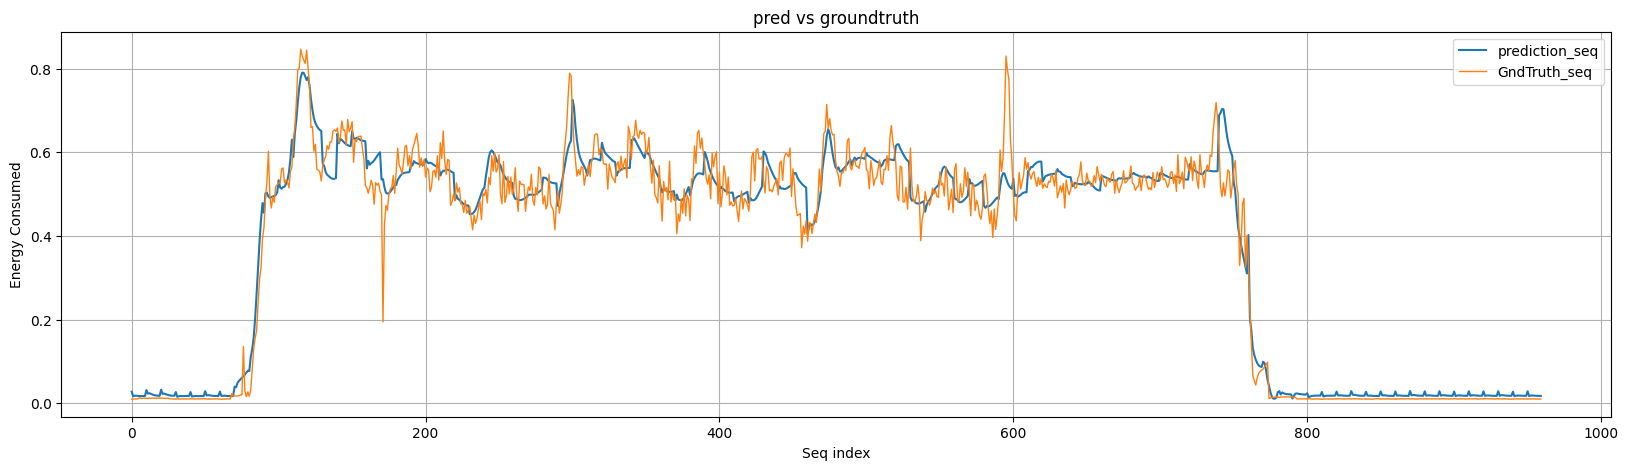

In [12]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load(f'TCN_LSTM_select_best_model_{input_len}-{output_len}.pt'))

# Test the model
seq2seq.eval()
flight_num = 276 #random.randint(0, 100)
test_data = data[data['flight'] == flight_num]
input_seq, output_seq = create_sequences(test_data[select_features].values, 
                                         test_data['power'].values,input_len,output_len)

input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

with torch.no_grad():
    
    outputs = seq2seq(input_seq)  # No need for target length
    # Adjust the dimensions if necessary, based on your loss function requirements
    # Example: If your outputs and targets are both [batch_size, 2, 1]
    outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
    targets = output_seq

    error = nn.MSELoss()(outputs, targets)
    print(f"Test loss: {error}")

    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    print(f"MAPE: {mape}")
    
    plot_output(outputs.cpu(), targets.cpu(), output_len)


In [ ]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load(f'TCN_LSTM_select_best_model_{input_len}-{output_len}.pt'))

# Test the model
seq2seq.eval()
test_nums = d_split['test']
test_nums.remove(273)

for f_num in d_split['test']:
    test_data = data[data['flight'] == f_num]
    input_seq, output_seq = create_sequences(test_data[select_features].values, 
                                            test_data['power'].values,input_len,output_len)

    input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
    output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

    print(f"Flight {f_num}:")

    with torch.no_grad():
        
        outputs = seq2seq(input_seq)  # No need for target length
        # Adjust the dimensions if necessary, based on your loss function requirements
        # Example: If your outputs and targets are both [batch_size, 2, 1]
        outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
        targets = output_seq
    
        error = nn.MSELoss()(outputs, targets)
        print(f"Test loss: {error}")

        mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
        print(f"MAPE: {mape}")

Flight 3:
Test loss: 0.0029777002055197954
MAPE: 20.976139068603516
Flight 124:
Test loss: 0.0030685586389154196
MAPE: 23.235849380493164
Flight 16:
Test loss: 0.002526950789615512
MAPE: 15.568193435668945
Flight 262:
Test loss: 0.0015653102891519666
MAPE: 12.082917213439941
Flight 221:
Test loss: 0.000739866984076798
MAPE: 4.631964206695557
Flight 94:
Test loss: 0.0017463592812418938
MAPE: 30.918466567993164
Flight 255:
Test loss: 0.0023565231822431087
MAPE: 50.98945617675781
Flight 263:
Test loss: 0.0007374652777798474
MAPE: 10.856463432312012
Flight 135:
Test loss: 0.0024245651438832283
MAPE: 14.360305786132812
Flight 17:
Test loss: 0.00281249126419425
MAPE: 11.953807830810547
Flight 233:
Test loss: 0.00119493727106601
MAPE: 11.382669448852539
Flight 20:
Test loss: 0.002853426383808255
MAPE: 9.975415229797363
Flight 228:
Test loss: 0.003140621120110154
MAPE: 43.71738815307617
Flight 113:
Test loss: 0.0036895377561450005
MAPE: 25.253582000732422
Flight 193:
Test loss: 0.0015225546667

In [13]:
# test the model
seq2seq.eval()
mape_list = []

for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    with torch.no_grad():
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1)
        
    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    mape_list.append(mape.item())

print(f"Test MAPE: {sum(mape_list)/len(mape_list)}")


Test MAPE: 32.42445108471647


It seems LSTM-LSTM is better than current design of TCN-LSTM